# Implicit Updates Stochastic Gradient Descent (ISGD)


## Imports

In [10]:
from src.helpers import *

## ISGD Implementation

In [11]:
class ISGD(SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _initialize(self, n_features):
        limit = np.sqrt(6.0 / (n_features + 1))
        self.weights = self.rng.uniform(-limit, limit, n_features)
        self.bias = 0.0

    def fit(self, x, y):
        global n_features
        x = np.asarray(x)
        y = np.asarray(y)
        m, n = x.shape
        self._initialize(n)
        self.loss_history = []

        t0 = time.perf_counter()
        tracemalloc.start()

        for epoch in range(self.epochs):
            idx = self.rng.permutation(m)
            xs, ys = x[idx], y[idx]
            lr = self._get_lr(epoch)

            for start in range(0, m, self.batch_size):
                xb = xs[start: start + self.batch_size]
                yb = ys[start: start + self.batch_size]
                bs, n_features = xb.shape

                X_tilde = np.hstack([xb, np.ones((bs, 1))])
                p_old = np.concatenate([self.weights, np.array([self.bias])])

                # Задача минимизации: min_p 0.5*||X_tilde*p - yb||^2 + (1/(2*lr))*||p - p_old||^2
                # Оптимальное условие: (X_tilde^T X_tilde + I/lr)*p_new = X_tilde^T*yb + p_old/lr
                A = X_tilde.T @ X_tilde + np.eye(n_features + 1) / lr
                b_vec = X_tilde.T @ yb + p_old / lr
                p_new = np.linalg.solve(A, b_vec)

                self.weights = p_new[:-1]
                self.bias = p_new[-1]

            full_pred = x @ self.weights + self.bias
            loss = np.mean((full_pred - y) ** 2)
            self.loss_history.append(loss)

        t1 = time.perf_counter()
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.training_time = t1 - t0
        self.memory_used = peak

        ops_per_sample = (n_features + 1) ** 2 + 2
        self.flops_count = self.epochs * m * ops_per_sample
        return self

    def predict(self, X):
        return np.asarray(X) @ self.weights + self.bias

## Benchmark

Parameters - , 


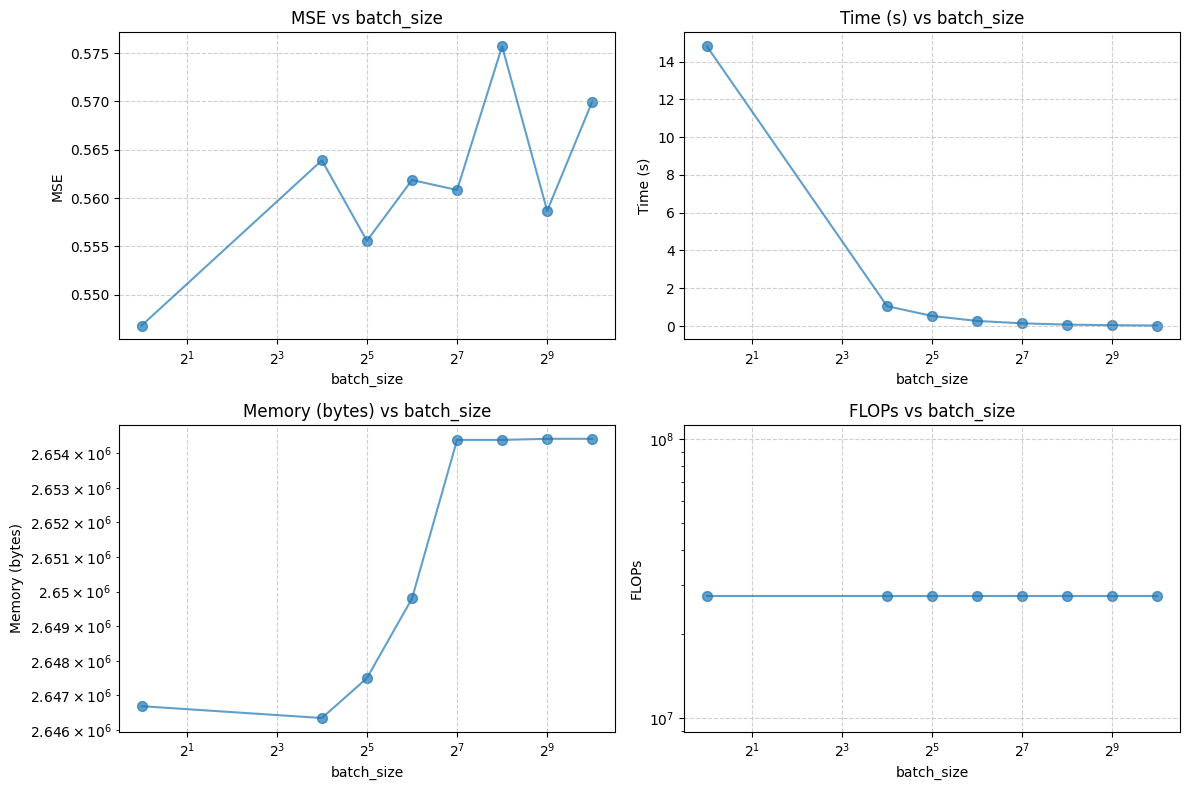

In [12]:
models = []
x, y = load_california(scale=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
for bs in [1, 16, 32, 64, 128, 256, 512, 1024]:
    model = ISGD(batch_size=bs)
    model.fit(x_train, y_train)
    models.append(model)

plot_performance_metrics(models)